In [1]:
import os
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor, Lambda, Compose
from torchvision import transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

import pandas as pd
from PIL import Image

class FNDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, train=True):
        self.img_labels = pd.read_csv(annotations_file, header=None)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.train = train

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = Image.open(os.path.join(self.img_dir, img_path)).convert('RGB')
        if not self.train: #for test
            image = image.crop((2, 3, 100-2, 70-3))
        
        
        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            transform = []
            transform.append(T.ToTensor())
            transform.append(T.Normalize([0.5]*3, [0.5]*3))
            transform = T.Compose(transform)
            image = transform(image)
            
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = torch.squeeze(model(X))
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch+1 == len(dataloader):
            loss, current, total_it = loss.item(), batch+1, len(dataloader)
            print(f"loss: {loss:>7f} [{current:>5d}/{total_it:>5d}]")
            
def train2m(dataloader, model, model2, loss_fn, optimizer, optimizer2):
    size = len(dataloader.dataset)
    model.train()
    model2.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        pred = torch.squeeze(model2(model(X)))
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        optimizer2.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer2.step()

        if batch+1 == len(dataloader):
            loss, current, total_it = loss.item(), batch+1, len(dataloader)
            print(f"loss: {loss:>7f} [{current:>5d}/{total_it:>5d}]")

import scipy.io
def test(dataloader, model, loss_fn, save=False, batch_size=64):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    
    test_loss, correct = 0, 0
    count = 0;
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = X[:,:,0+8:64-8,0+8:96-8] #center
            
            pred = model(X)
            m = nn.Softmax(dim=1)
            pred = m(pred)
            
            actual = y
            
            test_loss += loss_fn(pred, actual).item()   
            correct += (pred.argmax(1) == actual).type(torch.float).sum().item()
            
            if save:
                if count == 0:
                    Pred = pred
                    Actual = actual
                else:
                    Pred = torch.cat((Pred, pred), 0)
                    Actual = torch.cat((Actual, actual), 0)
                count = count + 1
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    if save:
        scipy.io.savemat(out_path+'scores-'+str(batch_size)+'.mat',{'Pred':Pred.cpu().numpy(),'Actual':Actual.cpu().numpy(),'Accuracy':correct,'Loss':test_loss})
        

def test_align(dataloader, model, loss_fn, center=False, save=False, batch_size=64):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    count = 0;
    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            if i%100 == 0:
                print(i)
            X, y = X.to(device), y.to(device)
            
            X_this = torch.zeros(X.shape).to(device)
            pred_this = torch.zeros([X.size(dim=0),190,8,8]).to(device)
            for shifti in range(1,8+1):
                for shiftj in range(1,8+1):
                    X_this[:,:,0:64-shifti,0:96-shiftj] = X[:,:,0+shifti:64,0+shiftj:96]
                    X_this[:,:,64-shifti:64,96-shiftj:96] = X[:,:,0:shifti,0:shiftj]
                    X_this[:,:,64-shifti:64,0:96-shiftj] = X[:,:,0:shifti,0+shiftj:96]
                    X_this[:,:,0:64-shifti,96-shiftj:96] = X[:,:,0+shifti:64,0:shiftj]
                    
                    if center:
                        X_in = X_this[:,:,0+8:64-8,0+8:96-8] #center
                    else:
                        X_in = X_this
                    
                    pred = model(X_in)
                    m = nn.Softmax(dim=1)
                    pred = m(pred)
                    
                    
                    if pred.dim() == 4:
                        pred = pred.reshape(pred.size(0),pred.size(1),pred.size(2)*pred.size(3))
                        temp, _ = torch.max(pred,1)
                        _, idx = torch.max(temp,1)
                        pred = pred[:,:,idx].reshape(pred.size(0),pred.size(1))
                    pred_this[:,:,shifti-1,shiftj-1] = pred
            
            pred_this = pred_this.reshape(pred_this.size(0),pred_this.size(1),pred_this.size(2)*pred_this.size(3))
            temp, _ = torch.max(pred_this,1)
            _, idx = torch.max(temp,1)
            pred = pred_this[:,:,idx].reshape(pred_this.size(0),pred_this.size(1))
            actual = y
            
            test_loss += loss_fn(pred, actual).item()   
            correct += (pred.argmax(1) == actual).type(torch.float).sum().item()
            if save:
                if count == 0:
                    Pred = pred
                    Actual = actual
                else:
                    Pred = torch.cat((Pred, pred), 0)
                    Actual = torch.cat((Actual, actual), 0)
                count = count + 1
                
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if save:
        scipy.io.savemat(out_path+'scores-align-'+str(batch_size)+'.mat',{'Pred':Pred.cpu().numpy(),'Actual':Actual.cpu().numpy(),'Accuracy':correct,'Loss':test_loss})
    
            
def test_align2m(dataloader, model, model2, loss_fn, center=False, save=False, batch_size=64):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    model2.eval()
    test_loss, correct = 0, 0
    count = 0;
    
    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            if i%100 == 0:
                print(i)
            X, y = X.to(device), y.to(device)
            
            X_this = torch.zeros(X.shape).to(device)
            pred_this = torch.zeros([X.size(dim=0),190,8,8]).to(device)
            for shifti in range(1,8+1):
                for shiftj in range(1,8+1):
                    X_this[:,:,0:64-shifti,0:96-shiftj] = X[:,:,0+shifti:64,0+shiftj:96]
                    X_this[:,:,64-shifti:64,96-shiftj:96] = X[:,:,0:shifti,0:shiftj]
                    X_this[:,:,64-shifti:64,0:96-shiftj] = X[:,:,0:shifti,0+shiftj:96]
                    X_this[:,:,0:64-shifti,96-shiftj:96] = X[:,:,0+shifti:64,0:shiftj]
                    
                    if center:
                        X_in = X_this[:,:,0+8:64-8,0+8:96-8] #center
                    else:
                        X_in = X_this
                    
                    pred = model2(model(X_in))
                    m = nn.Softmax(dim=1)
                    pred = m(pred)
                    
                    if pred.dim() == 4:
                        pred = pred.reshape(pred.size(0),pred.size(1),pred.size(2)*pred.size(3))
                        temp, _ = torch.max(pred,1)
                        _, idx = torch.max(temp,1)
                        pred = pred[:,:,idx].reshape(pred.size(0),pred.size(1))
                    pred_this[:,:,shifti-1,shiftj-1] = pred
            
            pred_this = pred_this.reshape(pred_this.size(0),pred_this.size(1),pred_this.size(2)*pred_this.size(3)) 
            temp, _ = torch.max(pred_this,1)
            _, idx = torch.max(temp,1)
            pred = pred_this[:,:,idx].reshape(pred_this.size(0),pred_this.size(1))
            actual = y
            
            test_loss += loss_fn(pred, actual).item()   
            correct += (pred.argmax(1) == actual).type(torch.float).sum().item()
            if save:
                if count == 0:
                    Pred = pred
                    Actual = actual
                else:
                    Pred = torch.cat((Pred, pred), 0)
                    Actual = torch.cat((Actual, actual), 0)
                count = count + 1
                
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if save:
        scipy.io.savemat(out_path+'scores-align-'+str(batch_size)+'.mat',{'Pred':Pred.cpu().numpy(),'Actual':Actual.cpu().numpy(),'Accuracy':correct,'Loss':test_loss})
    
            
def test_align_match(train_dataloader, test_dataloader, model, center=False, save=False, batch_size=64, sim=1):
    model.eval()
    
    with torch.no_grad():
        count = 0;
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            actual = y
            if save:
                if count == 0:
                    Pred = pred
                    Actual = actual
                else:
                    Pred = torch.cat((Pred, pred), 0)
                    Actual = torch.cat((Actual, actual), 0)
                count = count + 1
        Pred_train = torch.squeeze(Pred)

    
        size = len(test_dataloader.dataset)
        num_batches = len(test_dataloader)
        
        test_loss, correct = 0, 0
        count = 0;
        for i, (X, y) in enumerate(test_dataloader):
            if i%100 == 0:
                print(i)
            X, y = X.to(device), y.to(device)
            
            X_this = torch.zeros(X.shape).to(device)
            dist_this = torch.zeros([X.size(dim=0),Pred_train.size(dim=0),8,8]).to(device)
            for shifti in range(1,8+1):
                for shiftj in range(1,8+1):
                    X_this[:,:,0:64-shifti,0:96-shiftj] = X[:,:,0+shifti:64,0+shiftj:96]
                    X_this[:,:,64-shifti:64,96-shiftj:96] = X[:,:,0:shifti,0:shiftj]
                    X_this[:,:,64-shifti:64,0:96-shiftj] = X[:,:,0:shifti,0+shiftj:96]
                    X_this[:,:,0:64-shifti,96-shiftj:96] = X[:,:,0+shifti:64,0:shiftj]
                    
                    if center:
                        X_in = X_this[:,:,0+8:64-8,0+8:96-8] #center
                        pred = model(X_in)
                        temp1 = Pred_train.repeat(pred.size(dim=0),1,1)
                        temp2 = torch.squeeze(pred).repeat(Pred_train.size(dim=0),1,1).permute((1,0,2))
                        if sim == 1:
                            temp3 = -torch.square(temp1-temp2)
                            temp4 = torch.mean(temp3, 2)
                        else:
                            cos = nn.CosineSimilarity(dim=2)
                            temp4 = cos(temp1, temp2)
                        dist = temp4
                    else:
                        X_in = X_this

                        pred = model(X_in)
                        dist = torch.zeros([X.size(dim=0),Pred_train.size(dim=0),3,3]).to(device)
                        for shifti3 in range(0,3):
                            for shiftj3 in range(0,3):
                                temp1 = Pred_train.repeat(pred.size(dim=0),1,1)
                                temp2 = torch.squeeze(pred[:,:,shifti3,shiftj3]).repeat(Pred_train.size(dim=0),1,1).permute((1,0,2)) #190, batch_size,1000
                                if sim == 1:
                                    temp3 = -torch.square(temp1-temp2)
                                    temp4 = torch.mean(temp3, 2)
                                else:
                                    cos = nn.CosineSimilarity(dim=2)
                                    temp4 = cos(temp1, temp2)
                                dist[:,:,shifti3,shiftj3] = temp4
                        dist, _ = torch.max(dist,3)
                        dist, _ = torch.max(dist,2)

                    dist_this[:,:,shifti-1,shiftj-1] = dist
            
            dist, _ = torch.max(dist_this,3)
            dist, _ = torch.max(dist,2)
            actual = y
            
            test_loss += torch.mean(dist).item()   
            correct += (dist.argmax(1) == actual).type(torch.float).sum().item()
            if save:
                if count == 0:
                    Pred = dist
                    Actual = actual
                else:
                    Pred = torch.cat((Pred, dist), 0)
                    Actual = torch.cat((Actual, actual), 0)
                count = count + 1
                
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if save:
        if sim == 1:
            scipy.io.savemat(out_path+'scores-align-match-'+str(batch_size)+'.mat',{'Pred':Pred.cpu().numpy(),'Actual':Actual.cpu().numpy(),'Accuracy':correct,'Loss':test_loss})
        else:
            scipy.io.savemat(out_path+'scores-align-match-cos-'+str(batch_size)+'.mat',{'Pred':Pred.cpu().numpy(),'Actual':Actual.cpu().numpy(),'Accuracy':correct,'Loss':test_loss})
    

def denorm(x):
        """Convert the range from [-1, 1] to [0, 1]."""
        out = (x + 1) / 2
        return out.clamp_(0, 1)

Model: 1
3990
1140
Feature batch shape: torch.Size([64, 3, 48, 80])
Label batch shape: torch.Size([64])


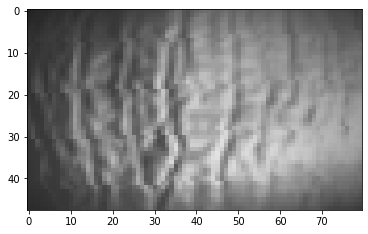

Label: 109
Using cuda device
Epoch 1
-------------------------------
loss: 0.768933 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 2
-------------------------------
loss: 0.063949 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 3
-------------------------------
loss: 0.067245 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 4
-------------------------------
loss: 0.027075 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 5
-------------------------------
loss: 0.022946 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 6
-------------------------------
loss: 0.017404 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 7
-------------------------------
loss: 0.018705 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 8
-------------------------------
loss: 0.023785 [   63/   63]
Learning Rate [0.005]
-------------------

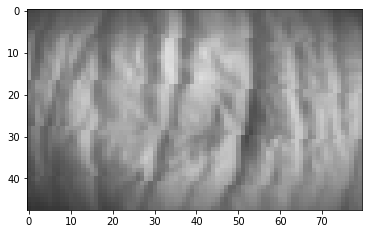

Label: 9
Using cuda device
Epoch 1
-------------------------------
loss: 0.107018 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 2
-------------------------------
loss: 0.014671 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 3
-------------------------------
loss: 0.010506 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 4
-------------------------------
loss: 0.007039 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 5
-------------------------------
loss: 0.005864 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 6
-------------------------------
loss: 0.006146 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 7
-------------------------------
loss: 0.005324 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 8
-------------------------------
loss: 0.003435 [   63/   63]
Learning Rate [0.005]
---------------------

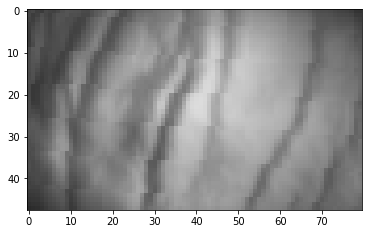

Label: 21
Using cuda device
Epoch 1
-------------------------------
loss: 0.093135 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 2
-------------------------------
loss: 0.034341 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 3
-------------------------------
loss: 0.026378 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 4
-------------------------------
loss: 0.018601 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 5
-------------------------------
loss: 0.015669 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 6
-------------------------------
loss: 0.012861 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 7
-------------------------------
loss: 0.012091 [   63/   63]
Learning Rate [0.005]
-------------------------------
Epoch 8
-------------------------------
loss: 0.012813 [   63/   63]
Learning Rate [0.005]
--------------------

In [2]:
for model_select in range(1,3+1):
    print('Model: ' + str(model_select))

    train_label_filename = 'train_label_shuffle.txt'
    test_label_filename = 'test_label.txt'

    data_path = "data_label_190/"
    out_path = 'task/' + 'model' + str(model_select) + '/'
    if not os.path.exists(out_path):
        os.makedirs(out_path)

    train_data = FNDataset(
        annotations_file = train_label_filename,
        img_dir = data_path,
        transform=True,
        train=True,
    )
    test_data = FNDataset(
        annotations_file = test_label_filename,
        img_dir = data_path,
        transform=True,
        train=False,
    )

    batch_size = 64 #64

    # Create data loaders.
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    print(len(train_dataloader.dataset))
    print(len(test_dataloader.dataset))

    # Display image and label.
    
    X, y = next(iter(train_dataloader))
    print(f"Feature batch shape: {X.size()}")
    print(f"Label batch shape: {y.size()}")
    img = X[0].squeeze().permute(1,2,0)
    label = y[0]

    img = denorm(img)
    plt.imshow(img, cmap='gray')
    plt.show()
    print(f"Label: {label}")
    
    
    # Get cpu or gpu device for training.
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")
    


    #Model Selection
    pretrain = True
    if model_select == 1:
        model = models.resnet50(pretrained=pretrain)
        model.fc = nn.Linear(2048, 190)
    elif model_select == 2:
        import fknet
        model = fknet.resnet50(pretrained=pretrain)
        model.fc = nn.Conv2d(832, 190, kernel_size=(6,10), stride=1, padding=0)
    elif model_select == 3:
        fea_size = 800
        import fknet
        model = fknet.resnet50(pretrained=pretrain)
        model.fc = nn.Sequential(nn.Conv2d(832, fea_size, kernel_size=(6,10), stride=1, padding=0),
                                 nn.ReLU(),nn.BatchNorm2d(fea_size) )
        model2 = nn.Conv2d(fea_size, 190, kernel_size=1, stride=1, padding=0)
        model2 = model2.to(device)
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()

    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    epochs = 50
    if model_select == 3:
        optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.005, momentum=0.9)
        scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=10, gamma=0.5)


    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        if model_select == 1:
            train(train_dataloader, model, loss_fn, optimizer)
            #test(test_dataloader, model, loss_fn, save=False, batch_size=batch_size)
            #test_align(test_dataloader, model, loss_fn, center=True, save=False, batch_size=batch_size)
        elif model_select == 2:
            train(train_dataloader, model, loss_fn, optimizer)
            #test_align(test_dataloader, model, loss_fn, center=False, save=False, batch_size=batch_size)
        elif model_select == 3:
            train2m(train_dataloader, model, model2, loss_fn, optimizer, optimizer2)
            #test_align2m(test_dataloader, model, model2, loss_fn, center=False, save=False, batch_size=batch_size)
            scheduler2.step()

        print(f"Learning Rate {scheduler.get_last_lr()}\n-------------------------------")
        scheduler.step()

    print("Done!")
    torch.save(model.state_dict(), os.path.join(out_path, 'model.pth'))
    if model_select == 3:
        torch.save(model2.state_dict(), os.path.join(out_path, 'model2.pth'))
    print("Saved PyTorch Model State")


In [3]:
#Classification Performance
for batch_size in [1]: #current implementation of test_align only supports batch_size = 1
    print('batch_size:' + str(batch_size))
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    for model_select in range(1,3+1):
        print('Model: ' + str(model_select))
        out_path = 'task/' + 'model' + str(model_select) + '/'
        
        #Model Selection
        pretrain = True
        if model_select == 1:
            model = models.resnet50(pretrained=pretrain)
            model.fc = nn.Linear(2048, 190)
        elif model_select == 2:
            import fknet
            model = fknet.resnet50(pretrained=pretrain)
            model.fc = nn.Conv2d(832, 190, kernel_size=(6,10), stride=1, padding=0)
        elif model_select == 3:
            fea_size = 800
            import fknet
            model = fknet.resnet50(pretrained=pretrain)
            model.fc = nn.Sequential(nn.Conv2d(832, fea_size, kernel_size=(6,10), stride=1, padding=0),
                                     nn.ReLU(),nn.BatchNorm2d(fea_size) )
            model2 = nn.Conv2d(fea_size, 190, kernel_size=1, stride=1, padding=0)
            model2 = model2.to(device)
        model = model.to(device)
        loss_fn = nn.CrossEntropyLoss()


        if model_select == 1:
            model.load_state_dict(torch.load(os.path.join(out_path, 'model.pth')))
            test_align(test_dataloader, model, loss_fn, center=True, save=True, batch_size=batch_size)
        elif model_select == 2:
            model.load_state_dict(torch.load(os.path.join(out_path, 'model.pth')))
            test_align(test_dataloader, model, loss_fn, center=False, save=True, batch_size=batch_size)
        elif model_select == 3:
            model.load_state_dict(torch.load(os.path.join(out_path, 'model.pth')))
            model2.load_state_dict(torch.load(os.path.join(out_path, 'model2.pth')))
            test_align2m(test_dataloader, model, model2, loss_fn, center=False, save=True, batch_size=batch_size)
       

batch_size:1
Model: 1
0
100
200
300
400
500
600
700
800
900
1000
1100
Test Error: 
 Accuracy: 47.0%, Avg loss: 4.888227 

Model: 2
0
100
200
300
400
500
600
700
800
900
1000
1100
Test Error: 
 Accuracy: 90.9%, Avg loss: 4.450680 

Model: 3
0
100
200
300
400
500
600
700
800
900
1000
1100
Test Error: 
 Accuracy: 92.0%, Avg loss: 4.581877 



In [4]:
#Feature Matching Performance
for batch_size in [1]: 
    print('batch_size:' + str(batch_size))
    train_data_set1 = FNDataset(
        annotations_file = 'train_label_set1.txt',
        img_dir = data_path,
        transform=True,
        train=True,
    )
    train_dataloader = DataLoader(train_data_set1, batch_size=190, shuffle=False)      
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    for model_select in range(2,3+1):
        print('Model: ' + str(model_select))
        out_path = 'task/' + 'model' + str(model_select) + '/'
        
        #Model Selection
        pretrain = True
        if model_select == 2:
            import fknet
            model = fknet.resnet50(pretrained=pretrain)
            model.fc = nn.Conv2d(832, 190, kernel_size=(6,10), stride=1, padding=0)
            model.load_state_dict(torch.load(os.path.join(out_path, 'model.pth')))
            model.fc = nn.Flatten()
        elif model_select == 3:
            fea_size = 800
            import fknet
            model = fknet.resnet50(pretrained=pretrain)
            model.fc = nn.Sequential(nn.Conv2d(832, fea_size, kernel_size=(6,10), stride=1, padding=0),
                                     nn.ReLU(),nn.BatchNorm2d(fea_size) )
            model2 = nn.Conv2d(fea_size, 190, kernel_size=1, stride=1, padding=0)
            model2 = model2.to(device)
        model = model.to(device)


        if model_select == 2:
            test_align_match(train_dataloader,test_dataloader, model, center=True, save=True, batch_size=batch_size)
            test_align_match(train_dataloader,test_dataloader, model, center=True, save=True, batch_size=batch_size, sim=2)
        elif model_select == 3:
            test_align_match(train_dataloader,test_dataloader, model, center=False, save=True, batch_size=batch_size)
            test_align_match(train_dataloader,test_dataloader, model, center=False, save=True, batch_size=batch_size, sim=2)


batch_size:1
Model: 2
0
100
200
300
400
500
600
700
800
900
1000
1100
Test Error: 
 Accuracy: 64.4%, Avg loss: -0.093124 

0
100
200
300
400
500
600
700
800
900
1000
1100
Test Error: 
 Accuracy: 65.4%, Avg loss: 0.672603 

Model: 3
0
100
200
300
400
500
600
700
800
900
1000
1100
Test Error: 
 Accuracy: 88.1%, Avg loss: -0.002676 

0
100
200
300
400
500
600
700
800
900
1000
1100
Test Error: 
 Accuracy: 87.4%, Avg loss: 0.859268 

